In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re

In [21]:
def clean_words(content,doc_bool):
    '''
    Drop stop words form tweets when model is not doc2vec
    Case-folding
    Remove len < 3 if alpha word
    :return: a clean word list
    '''
    if doc_bool == True:
        clean = [word.lower() for word in content]
        return ' '.join(clean)
    else:
        stops = set(['the', '<url>', '<user>'])
        clean = [word.lower() for word in content if not (word.isalpha() and len(word) <= 2) and not word in stops]
        return ' '.join(clean)


def cut_words(content):
    '''
    Tokenize the tweet to words
    :return: a cut word list
    '''
    if content != '' and content is not None:
        seg_list = word_tokenize(content)
        each_split = ' '.join(seg_list).split(' ')
    return each_split

def get_data_df(file_list):
    '''
    Saving all data into one dataframe
    '''
    data = []
    with open(file_list[0]) as f:
        for line in f:
            doc = line.replace("\t", "").replace("<user>", "").replace("\n", "").replace("<url>", "")
            data.append([doc,1])
    with open(file_list[1]) as f:
        for line in f:
            doc = line.replace("\t", "").replace("<user>", "").replace("\n", "").replace("<url>", "")
            data.append([doc,0])

    df = pd.DataFrame (data, columns = ['tweet', 'label'])
    
    return df

In [34]:
df = get_data_df(["twitter-datasets/train_pos.txt","twitter-datasets/train_neg.txt"])
df

,tweet,label
0,i dunno justin read my mention or not . only ...,1
1,"because your logic is so dumb , i won't even c...",1
2,""" just put casper in a box ! "" looved the bat...",1
3,thanks sir > > don't trip lil mama ... just ...,1
4,visiting my brother tmr is the bestest birthda...,1
...,...,...
199995,can't wait to fake tan tonight ! hate being pale,0
199996,darling i lost my internet connection .. and ...,0
199997,kanguru defender basic 4 gb usb 2.0 flash driv...,0
199998,rizan is sad now,0


In [35]:
# drop duplicates
df_pos = df[df['label'] == 1].copy().drop_duplicates(keep='first').reset_index(drop=True)
df_neg = df[df['label'] == 0].copy().drop_duplicates(keep='first').reset_index(drop=True)

In [38]:
# check conflicts
merged_df = pd.concat([df_pos, df_neg])
conflict_df = merged_df[merged_df.duplicated(['tweet'], keep=False)]
conflict_df.sort_values('tweet')

,tweet,label
3843,are you busy this weekend ?,1
29759,are you busy this weekend ?,0
85810,follow back po please,1
82910,follow back po please,0
47443,i need to see you,0
81374,i need to see you,1
89780,it's really not,0
11705,it's really not,1
63108,its a song,1
28409,its a song,0


In [40]:
# drop conflicts
df_pos = pd.concat([df_pos, conflict_df])
df_pos = df_pos.drop_duplicates(['tweet'],keep=False).reset_index(drop=True)
df_neg = pd.concat([df_neg, conflict_df])
df_neg = df_neg.drop_duplicates(['tweet'],keep=False).reset_index(drop=True)

df = pd.concat([df_pos, df_neg]).reset_index(drop=True)
temp = df['tweet'].apply(lambda x : x.split())
df['tweet'] = temp.apply(lambda x : clean_words(x, True))

In [43]:
temp = df['tweet'].apply(lambda x : x.split())
from collections import Counter

def word_cnt(wlist):
    '''
    Count the number of occurrences of each term in all paths
    '''
    word_counts = Counter()
    
    for word in wlist:
        word_counts.update(word)
    
    return sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

counter_list = word_cnt(temp)
counter_list[:20]

[('!', 75076),
 ('i', 75043),
 ('the', 54636),
 ('.', 54626),
 (',', 53301),
 ('to', 51647),
 ('you', 42808),
 ('(', 39188),
 ('a', 37848),
 ('...', 36037),
 ('and', 33066),
 ('my', 30552),
 ('me', 25426),
 ('?', 24549),
 ('of', 24086),
 ('is', 22600),
 ('for', 21986),
 ('in', 21616),
 ('it', 21013),
 ('"', 17978)]

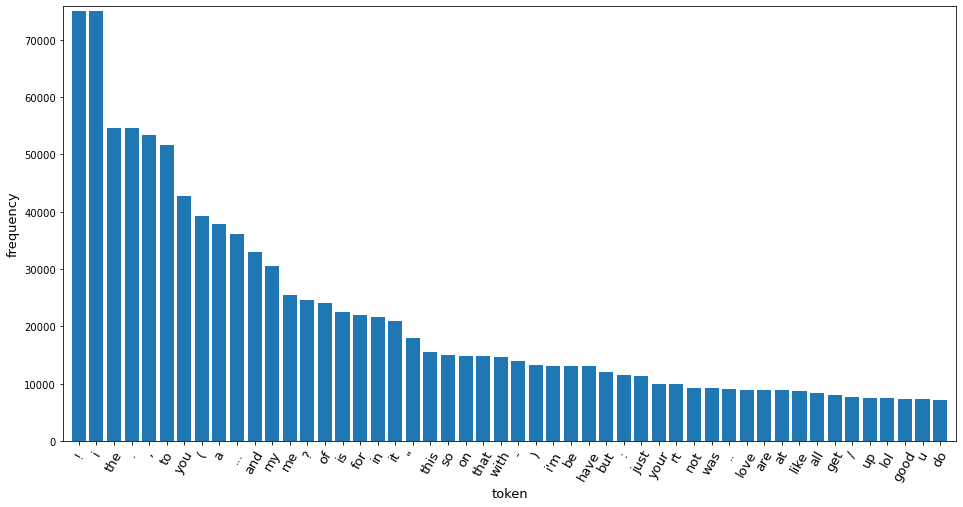

In [44]:
TOP20 = counter_list[:50]
a = np.array(TOP20)
y = [np.float64(i) for i in a[:,1]]

fig = plt.figure(figsize=(16,8))
plt.bar(a[:,0],y)
plt.xticks(rotation = 60,size = 13)
plt.ylabel('frequency',fontdict={'size' : 13})
plt.xlabel('token',fontdict={'size' : 13})
plt.margins(0.01)
plt.savefig('word frequency.jpg')

In [45]:
df.to_csv("part.csv",index = False)
df_pos.to_csv("part_pos.csv",index = False)
df_neg.to_csv("part_neg.csv",index = False)

In [46]:
len(df)

181292

In [119]:
# handle test data

data = []
with open("twitter-datasets/test_data.txt") as f:
    for line in f:
        line = ','.join(line.split(',')[1:])
        doc = line.replace("\t", "").replace("<user>", "").replace("\n", "").replace("<url>", "")
        data.append([doc])
df_test = pd.DataFrame (data, columns = ['tweet'])
df_test

,tweet
0,sea doo pro sea scooter ( sports with the port...
1,shucks well i work all week so now i can't co...
2,i cant stay away from bug thats my baby
3,no ma'am ! ! ! lol im perfectly fine and not ...
4,"whenever i fall asleep watching the tv , i alw..."
...,...
9995,had a nice time w / my friend lastnite
9996,no it's not ! please stop !
9997,not without my daughter ( dvd two-time oscar (...
9998,have fun in class sweetcheeks


In [120]:
temp = df_test['tweet'].apply(lambda x : cut_words(x))
df_test['tweet'] = temp.apply(lambda x : clean_words(x, True))
df_test.to_csv("test.csv",index = False)